In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import cv2
from tqdm.notebook import tqdm
import os
import numpy as np
from torchvision import datasets
from torchvision import transforms as T
from torchvision.io import read_image
import matplotlib.ticker as mtick
import io
import PIL.Image as Image
import matplotlib.ticker as mticker
import zipfile
import torchvision.models as models
from torch.optim import Adam, SGD
import torch.nn.functional as F
import random

%matplotlib inline

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
device

device(type='cuda')

#### Reading data

In [6]:
class HandDataset(Dataset):
    def __init__(self, train_p, train=True, transform=None, one_hot=False, zipf=False):
        self._train_p = train_p
        self._one_hot = one_hot
        self._train = train
        self._zipf = zipf
        self._train_x, self._train_y = self.__get_tensors()
    
    def __get_tensors(self):   
        if self._zipf:
            zf = zipfile.ZipFile(self._train_p, "r")
            if self._train:
                train_files = [i for i in zf.namelist() if ("train" in i) and (i.endswith("png"))]
            else:
                train_files = [i for i in zf.namelist() if ("test" in i) and (i.endswith("png"))]
            
            train_x = torch.stack(tuple(torch.from_numpy(self.__read_io_np(zf, f)) for f in train_files))
                
        else:
            train_files = [os.path.join(os.getcwd(), self._train_p, d) for d in os.listdir(self._train_p)]
            train_x = torch.stack(tuple(read_image(f) for f in train_files))
                
        if self._one_hot:  
            train_y = F.one_hot(torch.Tensor([int(f[-6]) for f in train_files]).long(), 6)
        else:
            train_y = torch.Tensor([int(f[-6]) for f in train_files]).long()
            
        return train_x, train_y
            
    
    def __read_io_np(self, zf, f):
        return np.array(Image.open(io.BytesIO(bytearray(zf.read(f)))))
        
        return train_x, train_y
    
    def __len__(self):
        return len(self._train_x)
    
    def __getitem__(self, idx):
        if transform:
            return torch.squeeze(transform(self._train_x[idx])), self._train_y[idx]
        return self._train_x, self._train_y
    
  

In [7]:
MEAN = [0.485, 0.456, 0.406]
STD = [0.229, 0.224, 0.225]

In [8]:
transform = T.Compose([
    T.ToPILImage(),
    T.ToTensor(),
    #T.Grayscale(),
    T.Lambda(lambda x: x.repeat(3, 1, 1)),
    T.Normalize(mean=MEAN, std=STD)
]
)

In [ ]:
train_ds = HandDataset(train_p="data.zip", train=True, transform=transform, one_hot=False, zipf=True)

In [10]:
test_ds = HandDataset(train_p="data.zip", train=False, transform=transform, one_hot=False, zipf=True)

#### Visualization

In [11]:
r_images = [random.randint(1, 10000) for _ in range(9)]

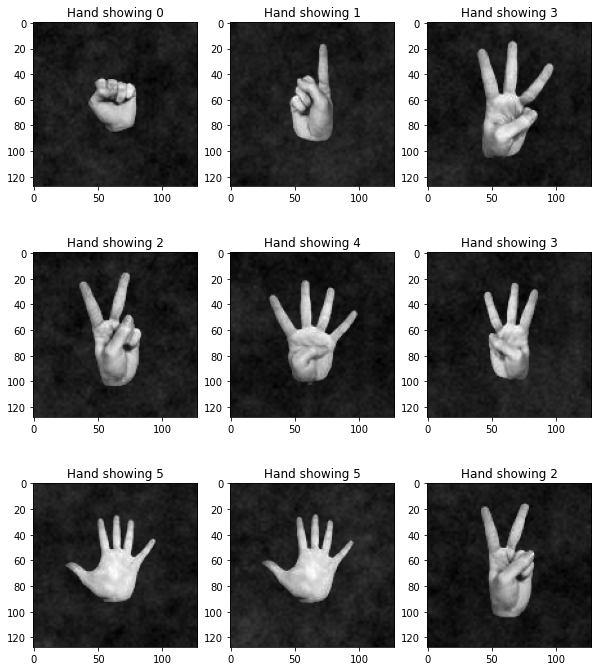

In [12]:
fig, axes = plt.subplots(3, 3, figsize=(10,12))
c = 0
for i in range(3):
    for j in range(3):
        axes[i, j].imshow(train_ds[r_images[c]][0][1], cmap="gray")
        axes[i, j].set_title("Hand showing {}".format(train_ds[r_images[c]][1]))
        c += 1

In [ ]:
def accuracy():
    pass 

In [13]:
model = models.densenet121(pretrained=True)

In [14]:
# def get_model(name="densenet121", 
#               layer="classifier", 
#               device = "cpu",
#               layer_num=0, **kwargs):
    
#     if name == "densenet121":
#         model = models.densenet121(pretrained=True).to(device)
#     elif name == "alexnet":
#         model = models.alexnet(pretrained=True).to(device)
#     elif name == "resnet":
#         model = models.resnet101(pretrained=True).to(device)
#     elif name == "vgg":
#         model = models.vgg11(pretrained=True).to(device)
#     else:
#         raise Exception("model not found")
        
#     if layer == "classifier":
#         model.classifier[layer_num](kwargs)
    
#     elif layer == "features":
#         model.features[layer_num](kwargs)
    
    
#     return model

In [15]:
model.classifier = nn.Linear(in_features=model.classifier.in_features, out_features=6, bias=True)

In [16]:
model = model.to(device)

In [17]:
train_batch = 64

In [18]:
test_batch = 32

In [19]:
train_loader = DataLoader(train_ds, train_batch, shuffle=True)

In [20]:
test_loader = DataLoader(test_ds, test_batch, shuffle=True)

In [21]:
num_epoch = 5

In [22]:
opt = Adam(model.parameters(), lr=0.001)

In [23]:
train_loss, train_acc = [], []
val_loss, val_acc = [], []

In [24]:
for ep in tqdm(range(num_epoch)):
    train_ep_loss, train_ep_acc = [], []
    val_ep_acc = []
    c = 0
    print("Training...")
    for im, label in tqdm(iter(train_loader)):
        im = im.to(device)
        label = label.to(device)
        
        model.train()
        opt.zero_grad()
        outp = model(im)
        loss = F.cross_entropy(outp, label)
        loss.backward()
        
        opt.step()
        
        train_ep_loss.append(loss.item())
    
    c_loss = np.mean(train_ep_loss)
    train_loss.append(c_loss)
    
    print("Train loss: {} \n".format(c_loss))
    
    print("Testing accuracy on train ...")
    for im, label in tqdm(iter(train_loader)):
        im = im.to(device)
        label = label.to(device)
        
        model.eval()
        with torch.no_grad():
            pred = model(im)
            correct = torch.argmax(pred, dim=1) == label
            train_ep_acc.extend(correct.cpu().numpy().tolist())
    
    c_acc1 = np.mean(train_ep_acc)
    train_acc.append(c_acc1)
    
    print("Train acc: {} \n".format(c_acc1))
    
    for im, label in tqdm(iter(test_loader)):
        im = im.to(device)
        label = label.to(device)
        
        model.eval()
        with torch.no_grad():
            pred = model(im)
            correct = torch.argmax(pred, dim=1) == label
            val_ep_acc.extend(correct.cpu().numpy().tolist())
    
    c_acc2 = np.mean(val_ep_acc)
    val_acc.append(c_acc2)
    
    print("Test acc: {}".format(c_acc2))

  0%|          | 0/5 [00:00<?, ?it/s]

Training...


  0%|          | 0/282 [00:00<?, ?it/s]

Train loss: 0.024919251192518813
Testing accuracy on train ...


  0%|          | 0/282 [00:00<?, ?it/s]

Train acc: 1.0


  0%|          | 0/113 [00:00<?, ?it/s]

Test acc: 1.0
Training...


  0%|          | 0/282 [00:00<?, ?it/s]

Train loss: 0.00032998409525063823
Testing accuracy on train ...


  0%|          | 0/282 [00:00<?, ?it/s]

Train acc: 0.9846666666666667


  0%|          | 0/113 [00:00<?, ?it/s]

Test acc: 0.9858333333333333
Training...


  0%|          | 0/282 [00:00<?, ?it/s]

Train loss: 0.012494091803227034
Testing accuracy on train ...


  0%|          | 0/282 [00:00<?, ?it/s]

Train acc: 1.0


  0%|          | 0/113 [00:00<?, ?it/s]

Test acc: 1.0
Training...


  0%|          | 0/282 [00:00<?, ?it/s]

Train loss: 7.167043152852177e-05
Testing accuracy on train ...


  0%|          | 0/282 [00:00<?, ?it/s]

Train acc: 1.0


  0%|          | 0/113 [00:00<?, ?it/s]

Test acc: 1.0
Training...


  0%|          | 0/282 [00:00<?, ?it/s]

Train loss: 3.7468121729408584e-05
Testing accuracy on train ...


  0%|          | 0/282 [00:00<?, ?it/s]

Train acc: 1.0


  0%|          | 0/113 [00:00<?, ?it/s]

Test acc: 1.0
